<a href="https://colab.research.google.com/github/khataei/PE-classification-DeepLearning/blob/master/Tunned-1-CNN-activity-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Activity Classifier

In this notebook, we build a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint 
import os  
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


import kerastuner as kt
import IPython

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

# pooling layer parameters
maxpooling_pool_size = 2
avepooling_pool_size = 2


# convolutional layer architecture:
n_conv_1 = 256 # filters, a.k.a. kernels
k_conv_1 = 3 # kernel length
n_conv_2 = 256
k_conv_2 = 3 # kernel length
n_conv_3 = 256 # filters, a.k.a. kernels
k_conv_3 = 2 # kernel length

# dense layer architecture: 
n_dense_1 = 512
dropout_1 = 0.3
n_dense_2 = 256
dropout_2 = 0.25

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [3]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [4]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [5]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [6]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [7]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]

### Splitting and shuffeling the data

In [8]:
# split and shuffle
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [118]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation='relu', input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation='relu'))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation='relu'))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 44, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d_1 (Average (None, 21, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

#### Configure model

In [119]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [120]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [121]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [122]:
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/60
228/228 [==============================] - ETA: 3s - loss: 1.7859 - accuracy: 0.17 - ETA: 5s - loss: 1.7707 - accuracy: 0.16 - ETA: 6s - loss: 1.7488 - accuracy: 0.20 - ETA: 6s - loss: 1.7228 - accuracy: 0.22 - ETA: 6s - loss: 1.6972 - accuracy: 0.24 - ETA: 6s - loss: 1.6670 - accuracy: 0.26 - ETA: 6s - loss: 1.6335 - accuracy: 0.27 - ETA: 6s - loss: 1.6101 - accuracy: 0.29 - ETA: 6s - loss: 1.5776 - accuracy: 0.30 - ETA: 5s - loss: 1.5439 - accuracy: 0.32 - ETA: 5s - loss: 1.5345 - accuracy: 0.33 - ETA: 5s - loss: 1.5083 - accuracy: 0.34 - ETA: 5s - loss: 1.4797 - accuracy: 0.35 - ETA: 5s - loss: 1.4535 - accuracy: 0.36 - ETA: 5s - loss: 1.4458 - accuracy: 0.37 - ETA: 4s - loss: 1.4282 - accuracy: 0.38 - ETA: 4s - loss: 1.4078 - accuracy: 0.38 - ETA: 4s - loss: 1.4072 - accuracy: 0.39 - ETA: 4s - loss: 1.3912 - accuracy: 0.39 - ETA: 4s - loss: 1.3765 - accuracy: 0.40 - ETA: 4s - loss: 1.3632 - accuracy: 0.40 - ETA: 4s - loss: 1.3505 - accuracy: 0.41 - ETA: 4s - loss: 1.3396

228/228 [==============================] - ETA: 2s - loss: 0.6047 - accuracy: 0.78 - ETA: 4s - loss: 0.5639 - accuracy: 0.79 - ETA: 4s - loss: 0.5212 - accuracy: 0.81 - ETA: 4s - loss: 0.5107 - accuracy: 0.81 - ETA: 4s - loss: 0.5186 - accuracy: 0.80 - ETA: 4s - loss: 0.5146 - accuracy: 0.80 - ETA: 4s - loss: 0.5144 - accuracy: 0.81 - ETA: 4s - loss: 0.5171 - accuracy: 0.80 - ETA: 4s - loss: 0.5219 - accuracy: 0.80 - ETA: 4s - loss: 0.5262 - accuracy: 0.80 - ETA: 4s - loss: 0.5285 - accuracy: 0.80 - ETA: 4s - loss: 0.5286 - accuracy: 0.80 - ETA: 4s - loss: 0.5258 - accuracy: 0.80 - ETA: 4s - loss: 0.5224 - accuracy: 0.80 - ETA: 4s - loss: 0.5216 - accuracy: 0.80 - ETA: 4s - loss: 0.5172 - accuracy: 0.80 - ETA: 4s - loss: 0.5147 - accuracy: 0.80 - ETA: 4s - loss: 0.5124 - accuracy: 0.80 - ETA: 3s - loss: 0.5117 - accuracy: 0.80 - ETA: 3s - loss: 0.5095 - accuracy: 0.80 - ETA: 3s - loss: 0.5081 - accuracy: 0.81 - ETA: 3s - loss: 0.5064 - accuracy: 0.81 - ETA: 3s - loss: 0.5053 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.3115 - accuracy: 0.89 - ETA: 4s - loss: 0.3504 - accuracy: 0.87 - ETA: 4s - loss: 0.3420 - accuracy: 0.87 - ETA: 4s - loss: 0.3250 - accuracy: 0.88 - ETA: 4s - loss: 0.3293 - accuracy: 0.87 - ETA: 4s - loss: 0.3250 - accuracy: 0.87 - ETA: 4s - loss: 0.3209 - accuracy: 0.87 - ETA: 4s - loss: 0.3169 - accuracy: 0.88 - ETA: 4s - loss: 0.3102 - accuracy: 0.88 - ETA: 4s - loss: 0.3160 - accuracy: 0.88 - ETA: 4s - loss: 0.3112 - accuracy: 0.88 - ETA: 4s - loss: 0.3138 - accuracy: 0.88 - ETA: 4s - loss: 0.3151 - accuracy: 0.88 - ETA: 4s - loss: 0.3169 - accuracy: 0.88 - ETA: 4s - loss: 0.3144 - accuracy: 0.88 - ETA: 4s - loss: 0.3121 - accuracy: 0.88 - ETA: 3s - loss: 0.3092 - accuracy: 0.88 - ETA: 3s - loss: 0.3128 - accuracy: 0.88 - ETA: 3s - loss: 0.3138 - accuracy: 0.88 - ETA: 3s - loss: 0.3146 - accuracy: 0.88 - ETA: 3s - loss: 0.3154 - accuracy: 0.88 - ETA: 3s - loss: 0.3170 - accuracy: 0.88 - ETA: 3s - loss: 0.3161 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.3084 - accuracy: 0.89 - ETA: 4s - loss: 0.2861 - accuracy: 0.89 - ETA: 4s - loss: 0.2554 - accuracy: 0.90 - ETA: 4s - loss: 0.2566 - accuracy: 0.90 - ETA: 4s - loss: 0.2605 - accuracy: 0.90 - ETA: 4s - loss: 0.2534 - accuracy: 0.90 - ETA: 4s - loss: 0.2545 - accuracy: 0.90 - ETA: 4s - loss: 0.2636 - accuracy: 0.89 - ETA: 4s - loss: 0.2612 - accuracy: 0.89 - ETA: 4s - loss: 0.2609 - accuracy: 0.89 - ETA: 4s - loss: 0.2600 - accuracy: 0.89 - ETA: 4s - loss: 0.2615 - accuracy: 0.89 - ETA: 4s - loss: 0.2587 - accuracy: 0.90 - ETA: 4s - loss: 0.2581 - accuracy: 0.90 - ETA: 4s - loss: 0.2558 - accuracy: 0.90 - ETA: 4s - loss: 0.2532 - accuracy: 0.90 - ETA: 3s - loss: 0.2513 - accuracy: 0.90 - ETA: 3s - loss: 0.2545 - accuracy: 0.90 - ETA: 3s - loss: 0.2570 - accuracy: 0.90 - ETA: 3s - loss: 0.2574 - accuracy: 0.90 - ETA: 3s - loss: 0.2591 - accuracy: 0.90 - ETA: 3s - loss: 0.2589 - accuracy: 0.90 - ETA: 3s - loss: 0.2569 - accuracy

228/228 [==============================] - ETA: 3s - loss: 0.2507 - accuracy: 0.92 - ETA: 4s - loss: 0.2429 - accuracy: 0.91 - ETA: 4s - loss: 0.2369 - accuracy: 0.92 - ETA: 4s - loss: 0.2293 - accuracy: 0.92 - ETA: 4s - loss: 0.2284 - accuracy: 0.91 - ETA: 4s - loss: 0.2275 - accuracy: 0.91 - ETA: 4s - loss: 0.2325 - accuracy: 0.91 - ETA: 4s - loss: 0.2277 - accuracy: 0.91 - ETA: 4s - loss: 0.2363 - accuracy: 0.91 - ETA: 4s - loss: 0.2337 - accuracy: 0.91 - ETA: 4s - loss: 0.2308 - accuracy: 0.91 - ETA: 4s - loss: 0.2303 - accuracy: 0.91 - ETA: 4s - loss: 0.2318 - accuracy: 0.91 - ETA: 4s - loss: 0.2325 - accuracy: 0.91 - ETA: 4s - loss: 0.2322 - accuracy: 0.91 - ETA: 4s - loss: 0.2309 - accuracy: 0.91 - ETA: 3s - loss: 0.2313 - accuracy: 0.91 - ETA: 3s - loss: 0.2320 - accuracy: 0.91 - ETA: 3s - loss: 0.2289 - accuracy: 0.91 - ETA: 3s - loss: 0.2273 - accuracy: 0.91 - ETA: 3s - loss: 0.2280 - accuracy: 0.91 - ETA: 3s - loss: 0.2268 - accuracy: 0.91 - ETA: 3s - loss: 0.2260 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1632 - accuracy: 0.92 - ETA: 4s - loss: 0.2295 - accuracy: 0.91 - ETA: 4s - loss: 0.2107 - accuracy: 0.92 - ETA: 4s - loss: 0.2052 - accuracy: 0.92 - ETA: 4s - loss: 0.2116 - accuracy: 0.92 - ETA: 4s - loss: 0.2150 - accuracy: 0.92 - ETA: 4s - loss: 0.2160 - accuracy: 0.92 - ETA: 4s - loss: 0.2148 - accuracy: 0.92 - ETA: 4s - loss: 0.2176 - accuracy: 0.92 - ETA: 4s - loss: 0.2148 - accuracy: 0.92 - ETA: 4s - loss: 0.2122 - accuracy: 0.92 - ETA: 4s - loss: 0.2107 - accuracy: 0.92 - ETA: 4s - loss: 0.2100 - accuracy: 0.92 - ETA: 4s - loss: 0.2114 - accuracy: 0.92 - ETA: 4s - loss: 0.2094 - accuracy: 0.92 - ETA: 4s - loss: 0.2078 - accuracy: 0.92 - ETA: 3s - loss: 0.2078 - accuracy: 0.92 - ETA: 3s - loss: 0.2068 - accuracy: 0.92 - ETA: 3s - loss: 0.2073 - accuracy: 0.92 - ETA: 3s - loss: 0.2060 - accuracy: 0.92 - ETA: 3s - loss: 0.2052 - accuracy: 0.92 - ETA: 3s - loss: 0.2068 - accuracy: 0.92 - ETA: 3s - loss: 0.2066 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1963 - accuracy: 0.91 - ETA: 4s - loss: 0.1949 - accuracy: 0.92 - ETA: 4s - loss: 0.2110 - accuracy: 0.92 - ETA: 4s - loss: 0.1958 - accuracy: 0.92 - ETA: 4s - loss: 0.2024 - accuracy: 0.91 - ETA: 4s - loss: 0.1946 - accuracy: 0.92 - ETA: 4s - loss: 0.1947 - accuracy: 0.92 - ETA: 4s - loss: 0.1999 - accuracy: 0.92 - ETA: 4s - loss: 0.2123 - accuracy: 0.91 - ETA: 4s - loss: 0.2090 - accuracy: 0.92 - ETA: 4s - loss: 0.2021 - accuracy: 0.92 - ETA: 4s - loss: 0.2012 - accuracy: 0.92 - ETA: 4s - loss: 0.2005 - accuracy: 0.92 - ETA: 4s - loss: 0.1997 - accuracy: 0.92 - ETA: 4s - loss: 0.1986 - accuracy: 0.92 - ETA: 4s - loss: 0.1985 - accuracy: 0.92 - ETA: 4s - loss: 0.1985 - accuracy: 0.92 - ETA: 3s - loss: 0.1976 - accuracy: 0.92 - ETA: 3s - loss: 0.1976 - accuracy: 0.92 - ETA: 3s - loss: 0.1972 - accuracy: 0.92 - ETA: 3s - loss: 0.1984 - accuracy: 0.92 - ETA: 3s - loss: 0.1985 - accuracy: 0.92 - ETA: 3s - loss: 0.1970 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1679 - accuracy: 0.93 - ETA: 4s - loss: 0.1944 - accuracy: 0.93 - ETA: 4s - loss: 0.1851 - accuracy: 0.93 - ETA: 4s - loss: 0.1729 - accuracy: 0.93 - ETA: 4s - loss: 0.1838 - accuracy: 0.93 - ETA: 4s - loss: 0.1826 - accuracy: 0.93 - ETA: 4s - loss: 0.1913 - accuracy: 0.93 - ETA: 4s - loss: 0.1869 - accuracy: 0.93 - ETA: 4s - loss: 0.1874 - accuracy: 0.93 - ETA: 4s - loss: 0.1914 - accuracy: 0.93 - ETA: 4s - loss: 0.1912 - accuracy: 0.93 - ETA: 4s - loss: 0.1876 - accuracy: 0.93 - ETA: 4s - loss: 0.1856 - accuracy: 0.93 - ETA: 4s - loss: 0.1847 - accuracy: 0.93 - ETA: 4s - loss: 0.2110 - accuracy: 0.92 - ETA: 4s - loss: 0.2129 - accuracy: 0.92 - ETA: 4s - loss: 0.2128 - accuracy: 0.92 - ETA: 3s - loss: 0.2119 - accuracy: 0.92 - ETA: 3s - loss: 0.2093 - accuracy: 0.92 - ETA: 3s - loss: 0.2071 - accuracy: 0.92 - ETA: 3s - loss: 0.2070 - accuracy: 0.92 - ETA: 3s - loss: 0.2057 - accuracy: 0.92 - ETA: 3s - loss: 0.2037 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1091 - accuracy: 0.96 - ETA: 4s - loss: 0.1393 - accuracy: 0.94 - ETA: 4s - loss: 0.1472 - accuracy: 0.94 - ETA: 4s - loss: 0.1492 - accuracy: 0.94 - ETA: 4s - loss: 0.1505 - accuracy: 0.94 - ETA: 4s - loss: 0.1507 - accuracy: 0.94 - ETA: 4s - loss: 0.1545 - accuracy: 0.94 - ETA: 4s - loss: 0.1574 - accuracy: 0.94 - ETA: 4s - loss: 0.1581 - accuracy: 0.94 - ETA: 4s - loss: 0.1614 - accuracy: 0.94 - ETA: 4s - loss: 0.1631 - accuracy: 0.94 - ETA: 4s - loss: 0.1614 - accuracy: 0.94 - ETA: 4s - loss: 0.1602 - accuracy: 0.94 - ETA: 4s - loss: 0.1580 - accuracy: 0.94 - ETA: 4s - loss: 0.1603 - accuracy: 0.94 - ETA: 4s - loss: 0.1603 - accuracy: 0.94 - ETA: 4s - loss: 0.1604 - accuracy: 0.94 - ETA: 3s - loss: 0.1606 - accuracy: 0.94 - ETA: 3s - loss: 0.1605 - accuracy: 0.94 - ETA: 3s - loss: 0.1608 - accuracy: 0.94 - ETA: 3s - loss: 0.1623 - accuracy: 0.94 - ETA: 3s - loss: 0.1631 - accuracy: 0.94 - ETA: 3s - loss: 0.1635 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0746 - accuracy: 0.96 - ETA: 4s - loss: 0.1579 - accuracy: 0.93 - ETA: 4s - loss: 0.1629 - accuracy: 0.93 - ETA: 4s - loss: 0.1565 - accuracy: 0.94 - ETA: 4s - loss: 0.1619 - accuracy: 0.93 - ETA: 4s - loss: 0.1641 - accuracy: 0.93 - ETA: 4s - loss: 0.1640 - accuracy: 0.93 - ETA: 4s - loss: 0.1645 - accuracy: 0.93 - ETA: 4s - loss: 0.1653 - accuracy: 0.93 - ETA: 4s - loss: 0.1618 - accuracy: 0.93 - ETA: 4s - loss: 0.1579 - accuracy: 0.94 - ETA: 4s - loss: 0.1585 - accuracy: 0.93 - ETA: 4s - loss: 0.1586 - accuracy: 0.94 - ETA: 4s - loss: 0.1610 - accuracy: 0.94 - ETA: 4s - loss: 0.1628 - accuracy: 0.94 - ETA: 4s - loss: 0.1638 - accuracy: 0.93 - ETA: 4s - loss: 0.1630 - accuracy: 0.93 - ETA: 3s - loss: 0.1604 - accuracy: 0.94 - ETA: 3s - loss: 0.1633 - accuracy: 0.93 - ETA: 3s - loss: 0.1629 - accuracy: 0.93 - ETA: 3s - loss: 0.1632 - accuracy: 0.93 - ETA: 3s - loss: 0.1630 - accuracy: 0.93 - ETA: 3s - loss: 0.1622 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 4s - loss: 0.1432 - accuracy: 0.95 - ETA: 4s - loss: 0.1409 - accuracy: 0.94 - ETA: 4s - loss: 0.1479 - accuracy: 0.94 - ETA: 4s - loss: 0.1414 - accuracy: 0.94 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 4s - loss: 0.1402 - accuracy: 0.94 - ETA: 4s - loss: 0.1417 - accuracy: 0.94 - ETA: 4s - loss: 0.1390 - accuracy: 0.94 - ETA: 4s - loss: 0.1408 - accuracy: 0.94 - ETA: 4s - loss: 0.1399 - accuracy: 0.94 - ETA: 4s - loss: 0.1385 - accuracy: 0.94 - ETA: 4s - loss: 0.1382 - accuracy: 0.94 - ETA: 4s - loss: 0.1375 - accuracy: 0.94 - ETA: 4s - loss: 0.1349 - accuracy: 0.95 - ETA: 4s - loss: 0.1377 - accuracy: 0.95 - ETA: 3s - loss: 0.1376 - accuracy: 0.94 - ETA: 3s - loss: 0.1389 - accuracy: 0.94 - ETA: 3s - loss: 0.1398 - accuracy: 0.94 - ETA: 3s - loss: 0.1406 - accuracy: 0.94 - ETA: 3s - loss: 0.1396 - accuracy: 0.94 - ETA: 3s - loss: 0.1412 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1487 - accuracy: 0.93 - ETA: 4s - loss: 0.1680 - accuracy: 0.93 - ETA: 4s - loss: 0.1478 - accuracy: 0.94 - ETA: 4s - loss: 0.1391 - accuracy: 0.94 - ETA: 4s - loss: 0.1384 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1398 - accuracy: 0.94 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 4s - loss: 0.1387 - accuracy: 0.94 - ETA: 4s - loss: 0.1387 - accuracy: 0.94 - ETA: 4s - loss: 0.1413 - accuracy: 0.94 - ETA: 4s - loss: 0.1413 - accuracy: 0.94 - ETA: 4s - loss: 0.1385 - accuracy: 0.94 - ETA: 4s - loss: 0.1393 - accuracy: 0.94 - ETA: 4s - loss: 0.1389 - accuracy: 0.94 - ETA: 4s - loss: 0.1400 - accuracy: 0.94 - ETA: 3s - loss: 0.1400 - accuracy: 0.94 - ETA: 3s - loss: 0.1390 - accuracy: 0.94 - ETA: 3s - loss: 0.1403 - accuracy: 0.94 - ETA: 3s - loss: 0.1414 - accuracy: 0.94 - ETA: 3s - loss: 0.1418 - accuracy: 0.94 - ETA: 3s - loss: 0.1412 - accuracy: 0.94 - ETA: 3s - loss: 0.1418 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1698 - accuracy: 0.92 - ETA: 4s - loss: 0.1352 - accuracy: 0.93 - ETA: 4s - loss: 0.1344 - accuracy: 0.94 - ETA: 4s - loss: 0.1296 - accuracy: 0.94 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1248 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1281 - accuracy: 0.95 - ETA: 3s - loss: 0.1277 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1272 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1889 - accuracy: 0.92 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1347 - accuracy: 0.94 - ETA: 4s - loss: 0.1355 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1347 - accuracy: 0.95 - ETA: 4s - loss: 0.1457 - accuracy: 0.94 - ETA: 4s - loss: 0.1447 - accuracy: 0.94 - ETA: 4s - loss: 0.1442 - accuracy: 0.94 - ETA: 4s - loss: 0.1451 - accuracy: 0.94 - ETA: 4s - loss: 0.1451 - accuracy: 0.94 - ETA: 4s - loss: 0.1433 - accuracy: 0.94 - ETA: 4s - loss: 0.1443 - accuracy: 0.94 - ETA: 3s - loss: 0.1437 - accuracy: 0.94 - ETA: 3s - loss: 0.1424 - accuracy: 0.94 - ETA: 3s - loss: 0.1421 - accuracy: 0.94 - ETA: 3s - loss: 0.1443 - accuracy: 0.94 - ETA: 3s - loss: 0.1435 - accuracy: 0.94 - ETA: 3s - loss: 0.1429 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1260 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1316 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 4s - loss: 0.1340 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1248 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - accuracy: 0.95 - ETA: 3s - loss: 0.1256 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1231 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 4s - loss: 0.0965 - accuracy: 0.96 - ETA: 4s - loss: 0.0951 - accuracy: 0.96 - ETA: 4s - loss: 0.1053 - accuracy: 0.95 - ETA: 4s - loss: 0.1059 - accuracy: 0.95 - ETA: 4s - loss: 0.1056 - accuracy: 0.96 - ETA: 4s - loss: 0.1028 - accuracy: 0.96 - ETA: 4s - loss: 0.1049 - accuracy: 0.95 - ETA: 4s - loss: 0.1039 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.95 - ETA: 4s - loss: 0.1073 - accuracy: 0.95 - ETA: 4s - loss: 0.1090 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.96 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1097 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1102 - accuracy: 0.95 - ETA: 3s - loss: 0.1104 - accuracy: 0.95 - ETA: 3s - loss: 0.1098 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1071 - accuracy: 0.96 - ETA: 4s - loss: 0.1081 - accuracy: 0.96 - ETA: 4s - loss: 0.1081 - accuracy: 0.96 - ETA: 4s - loss: 0.1085 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.96 - ETA: 4s - loss: 0.1075 - accuracy: 0.96 - ETA: 4s - loss: 0.1069 - accuracy: 0.96 - ETA: 4s - loss: 0.1057 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.96 - ETA: 3s - loss: 0.1084 - accuracy: 0.95 - ETA: 3s - loss: 0.1075 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1107 - accuracy: 0.95 - ETA: 3s - loss: 0.1098 - accuracy: 0.95 - ETA: 3s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1116 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1089 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1071 - accuracy: 0.95 - ETA: 4s - loss: 0.1056 - accuracy: 0.95 - ETA: 4s - loss: 0.0999 - accuracy: 0.96 - ETA: 4s - loss: 0.0996 - accuracy: 0.96 - ETA: 4s - loss: 0.0966 - accuracy: 0.96 - ETA: 4s - loss: 0.0967 - accuracy: 0.96 - ETA: 4s - loss: 0.0974 - accuracy: 0.96 - ETA: 4s - loss: 0.0957 - accuracy: 0.96 - ETA: 4s - loss: 0.0957 - accuracy: 0.96 - ETA: 4s - loss: 0.0956 - accuracy: 0.96 - ETA: 4s - loss: 0.0964 - accuracy: 0.96 - ETA: 4s - loss: 0.0963 - accuracy: 0.96 - ETA: 3s - loss: 0.0960 - accuracy: 0.96 - ETA: 3s - loss: 0.0957 - accuracy: 0.96 - ETA: 3s - loss: 0.0958 - accuracy: 0.96 - ETA: 3s - loss: 0.0968 - accuracy: 0.96 - ETA: 3s - loss: 0.0959 - accuracy: 0.96 - ETA: 3s - loss: 0.0982 - accuracy: 0.96 - ETA: 3s - loss: 0.0993 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1054 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.96 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.96 - ETA: 4s - loss: 0.1109 - accuracy: 0.96 - ETA: 4s - loss: 0.1101 - accuracy: 0.96 - ETA: 4s - loss: 0.1097 - accuracy: 0.96 - ETA: 4s - loss: 0.1077 - accuracy: 0.96 - ETA: 4s - loss: 0.1043 - accuracy: 0.96 - ETA: 4s - loss: 0.1037 - accuracy: 0.96 - ETA: 3s - loss: 0.1047 - accuracy: 0.96 - ETA: 3s - loss: 0.1045 - accuracy: 0.96 - ETA: 3s - loss: 0.1037 - accuracy: 0.96 - ETA: 3s - loss: 0.1041 - accuracy: 0.96 - ETA: 3s - loss: 0.1042 - accuracy: 0.96 - ETA: 3s - loss: 0.1029 - accuracy: 0.96 - ETA: 3s - loss: 0.1028 - accuracy: 0.96 - ETA: 3s - loss: 0.1035 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0721 - accuracy: 0.96 - ETA: 4s - loss: 0.0918 - accuracy: 0.96 - ETA: 4s - loss: 0.0913 - accuracy: 0.95 - ETA: 4s - loss: 0.0875 - accuracy: 0.96 - ETA: 4s - loss: 0.0923 - accuracy: 0.96 - ETA: 4s - loss: 0.0922 - accuracy: 0.96 - ETA: 4s - loss: 0.0913 - accuracy: 0.96 - ETA: 4s - loss: 0.0916 - accuracy: 0.96 - ETA: 4s - loss: 0.0943 - accuracy: 0.96 - ETA: 4s - loss: 0.0949 - accuracy: 0.96 - ETA: 4s - loss: 0.0946 - accuracy: 0.96 - ETA: 4s - loss: 0.0953 - accuracy: 0.96 - ETA: 4s - loss: 0.0942 - accuracy: 0.96 - ETA: 4s - loss: 0.0958 - accuracy: 0.96 - ETA: 4s - loss: 0.0976 - accuracy: 0.96 - ETA: 4s - loss: 0.0978 - accuracy: 0.96 - ETA: 3s - loss: 0.0970 - accuracy: 0.96 - ETA: 3s - loss: 0.0964 - accuracy: 0.96 - ETA: 3s - loss: 0.0969 - accuracy: 0.96 - ETA: 3s - loss: 0.0977 - accuracy: 0.96 - ETA: 3s - loss: 0.0972 - accuracy: 0.96 - ETA: 3s - loss: 0.0968 - accuracy: 0.96 - ETA: 3s - loss: 0.0969 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0975 - accuracy: 0.97 - ETA: 4s - loss: 0.0940 - accuracy: 0.96 - ETA: 4s - loss: 0.0978 - accuracy: 0.96 - ETA: 4s - loss: 0.0935 - accuracy: 0.96 - ETA: 4s - loss: 0.0971 - accuracy: 0.96 - ETA: 4s - loss: 0.0953 - accuracy: 0.96 - ETA: 4s - loss: 0.0932 - accuracy: 0.96 - ETA: 4s - loss: 0.0926 - accuracy: 0.96 - ETA: 4s - loss: 0.0906 - accuracy: 0.96 - ETA: 4s - loss: 0.0902 - accuracy: 0.96 - ETA: 4s - loss: 0.0893 - accuracy: 0.96 - ETA: 4s - loss: 0.0896 - accuracy: 0.96 - ETA: 4s - loss: 0.0902 - accuracy: 0.96 - ETA: 4s - loss: 0.0907 - accuracy: 0.96 - ETA: 4s - loss: 0.0891 - accuracy: 0.96 - ETA: 3s - loss: 0.0878 - accuracy: 0.96 - ETA: 3s - loss: 0.0873 - accuracy: 0.96 - ETA: 3s - loss: 0.0870 - accuracy: 0.96 - ETA: 3s - loss: 0.0890 - accuracy: 0.96 - ETA: 3s - loss: 0.0883 - accuracy: 0.96 - ETA: 3s - loss: 0.0887 - accuracy: 0.96 - ETA: 3s - loss: 0.0882 - accuracy: 0.96 - ETA: 3s - loss: 0.0885 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.1436 - accuracy: 0.92 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1035 - accuracy: 0.95 - ETA: 4s - loss: 0.1032 - accuracy: 0.95 - ETA: 4s - loss: 0.1025 - accuracy: 0.96 - ETA: 4s - loss: 0.0993 - accuracy: 0.96 - ETA: 4s - loss: 0.1017 - accuracy: 0.96 - ETA: 4s - loss: 0.0975 - accuracy: 0.96 - ETA: 4s - loss: 0.0952 - accuracy: 0.96 - ETA: 4s - loss: 0.0944 - accuracy: 0.96 - ETA: 4s - loss: 0.0924 - accuracy: 0.96 - ETA: 4s - loss: 0.0914 - accuracy: 0.96 - ETA: 4s - loss: 0.0932 - accuracy: 0.96 - ETA: 4s - loss: 0.0930 - accuracy: 0.96 - ETA: 4s - loss: 0.0930 - accuracy: 0.96 - ETA: 4s - loss: 0.0938 - accuracy: 0.96 - ETA: 3s - loss: 0.0929 - accuracy: 0.96 - ETA: 3s - loss: 0.0926 - accuracy: 0.96 - ETA: 3s - loss: 0.0930 - accuracy: 0.96 - ETA: 3s - loss: 0.0936 - accuracy: 0.96 - ETA: 3s - loss: 0.0943 - accuracy: 0.96 - ETA: 3s - loss: 0.0943 - accuracy: 0.96 - ETA: 3s - loss: 0.0947 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0726 - accuracy: 0.96 - ETA: 4s - loss: 0.1096 - accuracy: 0.96 - ETA: 4s - loss: 0.1019 - accuracy: 0.96 - ETA: 4s - loss: 0.0967 - accuracy: 0.96 - ETA: 4s - loss: 0.1009 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.0975 - accuracy: 0.96 - ETA: 4s - loss: 0.0946 - accuracy: 0.96 - ETA: 4s - loss: 0.0951 - accuracy: 0.96 - ETA: 4s - loss: 0.0958 - accuracy: 0.96 - ETA: 4s - loss: 0.0941 - accuracy: 0.96 - ETA: 4s - loss: 0.0994 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.1001 - accuracy: 0.96 - ETA: 4s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.1002 - accuracy: 0.96 - ETA: 4s - loss: 0.0989 - accuracy: 0.96 - ETA: 3s - loss: 0.0993 - accuracy: 0.96 - ETA: 3s - loss: 0.1000 - accuracy: 0.96 - ETA: 3s - loss: 0.1002 - accuracy: 0.96 - ETA: 3s - loss: 0.1004 - accuracy: 0.96 - ETA: 3s - loss: 0.0992 - accuracy: 0.96 - ETA: 3s - loss: 0.0973 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0890 - accuracy: 0.96 - ETA: 4s - loss: 0.0703 - accuracy: 0.97 - ETA: 4s - loss: 0.0899 - accuracy: 0.96 - ETA: 4s - loss: 0.0903 - accuracy: 0.96 - ETA: 4s - loss: 0.0894 - accuracy: 0.96 - ETA: 4s - loss: 0.0864 - accuracy: 0.96 - ETA: 4s - loss: 0.0826 - accuracy: 0.97 - ETA: 4s - loss: 0.0786 - accuracy: 0.97 - ETA: 4s - loss: 0.0809 - accuracy: 0.97 - ETA: 4s - loss: 0.0799 - accuracy: 0.97 - ETA: 4s - loss: 0.0817 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0820 - accuracy: 0.96 - ETA: 4s - loss: 0.0823 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0831 - accuracy: 0.96 - ETA: 3s - loss: 0.0837 - accuracy: 0.96 - ETA: 3s - loss: 0.0838 - accuracy: 0.96 - ETA: 3s - loss: 0.0835 - accuracy: 0.96 - ETA: 3s - loss: 0.0834 - accuracy: 0.96 - ETA: 3s - loss: 0.0834 - accuracy: 0.96 - ETA: 3s - loss: 0.0836 - accuracy: 0.96 - ETA: 3s - loss: 0.0839 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0870 - accuracy: 0.97 - ETA: 4s - loss: 0.0917 - accuracy: 0.96 - ETA: 4s - loss: 0.0838 - accuracy: 0.96 - ETA: 4s - loss: 0.0837 - accuracy: 0.96 - ETA: 4s - loss: 0.0820 - accuracy: 0.96 - ETA: 4s - loss: 0.0796 - accuracy: 0.96 - ETA: 4s - loss: 0.0781 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0816 - accuracy: 0.96 - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 4s - loss: 0.0808 - accuracy: 0.96 - ETA: 4s - loss: 0.0806 - accuracy: 0.96 - ETA: 4s - loss: 0.0813 - accuracy: 0.96 - ETA: 4s - loss: 0.0809 - accuracy: 0.96 - ETA: 4s - loss: 0.0789 - accuracy: 0.97 - ETA: 4s - loss: 0.0803 - accuracy: 0.97 - ETA: 3s - loss: 0.0793 - accuracy: 0.97 - ETA: 3s - loss: 0.0780 - accuracy: 0.97 - ETA: 3s - loss: 0.0782 - accuracy: 0.97 - ETA: 3s - loss: 0.0781 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0791 - accuracy: 0.97 - ETA: 3s - loss: 0.0799 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 4s - loss: 0.1119 - accuracy: 0.96 - ETA: 4s - loss: 0.0956 - accuracy: 0.96 - ETA: 4s - loss: 0.1010 - accuracy: 0.96 - ETA: 4s - loss: 0.0951 - accuracy: 0.96 - ETA: 4s - loss: 0.0897 - accuracy: 0.96 - ETA: 4s - loss: 0.0967 - accuracy: 0.96 - ETA: 4s - loss: 0.0959 - accuracy: 0.96 - ETA: 4s - loss: 0.0934 - accuracy: 0.96 - ETA: 4s - loss: 0.0923 - accuracy: 0.96 - ETA: 4s - loss: 0.0921 - accuracy: 0.96 - ETA: 4s - loss: 0.0897 - accuracy: 0.96 - ETA: 4s - loss: 0.0899 - accuracy: 0.96 - ETA: 4s - loss: 0.0896 - accuracy: 0.96 - ETA: 4s - loss: 0.0894 - accuracy: 0.96 - ETA: 4s - loss: 0.0876 - accuracy: 0.96 - ETA: 3s - loss: 0.0886 - accuracy: 0.96 - ETA: 3s - loss: 0.0887 - accuracy: 0.96 - ETA: 3s - loss: 0.0879 - accuracy: 0.96 - ETA: 3s - loss: 0.0878 - accuracy: 0.96 - ETA: 3s - loss: 0.0874 - accuracy: 0.96 - ETA: 3s - loss: 0.0877 - accuracy: 0.96 - ETA: 3s - loss: 0.0866 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0582 - accuracy: 0.97 - ETA: 4s - loss: 0.0825 - accuracy: 0.96 - ETA: 4s - loss: 0.0822 - accuracy: 0.96 - ETA: 4s - loss: 0.0800 - accuracy: 0.96 - ETA: 4s - loss: 0.0811 - accuracy: 0.96 - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 4s - loss: 0.0773 - accuracy: 0.97 - ETA: 4s - loss: 0.0769 - accuracy: 0.97 - ETA: 4s - loss: 0.0764 - accuracy: 0.97 - ETA: 4s - loss: 0.0763 - accuracy: 0.97 - ETA: 4s - loss: 0.0774 - accuracy: 0.97 - ETA: 4s - loss: 0.0790 - accuracy: 0.97 - ETA: 4s - loss: 0.0796 - accuracy: 0.96 - ETA: 4s - loss: 0.0821 - accuracy: 0.96 - ETA: 4s - loss: 0.0815 - accuracy: 0.96 - ETA: 4s - loss: 0.0830 - accuracy: 0.96 - ETA: 4s - loss: 0.0830 - accuracy: 0.96 - ETA: 3s - loss: 0.0822 - accuracy: 0.96 - ETA: 3s - loss: 0.0813 - accuracy: 0.96 - ETA: 3s - loss: 0.0810 - accuracy: 0.96 - ETA: 3s - loss: 0.0820 - accuracy: 0.96 - ETA: 3s - loss: 0.0815 - accuracy: 0.96 - ETA: 3s - loss: 0.0815 - accuracy

228/228 [==============================] - ETA: 2s - loss: 0.0723 - accuracy: 0.95 - ETA: 4s - loss: 0.0694 - accuracy: 0.97 - ETA: 4s - loss: 0.0608 - accuracy: 0.97 - ETA: 4s - loss: 0.0594 - accuracy: 0.97 - ETA: 4s - loss: 0.0657 - accuracy: 0.97 - ETA: 4s - loss: 0.0668 - accuracy: 0.97 - ETA: 4s - loss: 0.0688 - accuracy: 0.97 - ETA: 4s - loss: 0.0658 - accuracy: 0.97 - ETA: 4s - loss: 0.0670 - accuracy: 0.97 - ETA: 4s - loss: 0.0667 - accuracy: 0.97 - ETA: 4s - loss: 0.0649 - accuracy: 0.97 - ETA: 4s - loss: 0.0659 - accuracy: 0.97 - ETA: 4s - loss: 0.0680 - accuracy: 0.97 - ETA: 4s - loss: 0.0702 - accuracy: 0.97 - ETA: 4s - loss: 0.0732 - accuracy: 0.97 - ETA: 4s - loss: 0.0734 - accuracy: 0.97 - ETA: 3s - loss: 0.0729 - accuracy: 0.97 - ETA: 3s - loss: 0.0723 - accuracy: 0.97 - ETA: 3s - loss: 0.0736 - accuracy: 0.97 - ETA: 3s - loss: 0.0740 - accuracy: 0.97 - ETA: 3s - loss: 0.0730 - accuracy: 0.97 - ETA: 3s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy

KeyboardInterrupt: 

#### Evaluate

In [38]:
model.load_weights(output_dir+"/weights.60.hdf5") # 96.29 val accuracy

In [101]:
y_hat = model.predict(X_valid)

In [102]:
len(y_hat)

6476

In [103]:
y_hat[0]

array([1.1744264e-03, 4.4644345e-08, 1.0289677e-08, 1.3867538e-06,
       8.6514185e-05, 9.9873763e-01], dtype=float32)

In [104]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

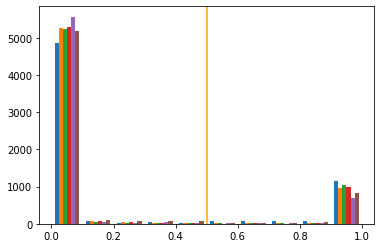

In [105]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [114]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [1.1744264e-03 4.4644345e-08 1.0289677e-08 1.3867538e-06 8.6514185e-05
 9.9873763e-01] [0. 0. 0. 0. 0. 1.]


94.64175416924027

In [91]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [92]:
"{:0.2f}".format(pct_auc)

'99.77'

In [93]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [94]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [95]:
ydf.head(10)

,y_hat,y
0,"[0.001, 0.0, 0.0, 0.0, 0.0, 0.999]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.002, 0.0, 0.0, 0.0, 0.0, 0.998]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.23, 0.752, 0.01, 0.0, 0.007, 0.001]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.114, 0.885, 0.0, 0.0, 0.001, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


## Tuning process

Using `for` loops and `checkpoints` to exhaustively search for the best hyperparameters is very time consuming. Therefore, we use the `keras-tuner` module to randomly search for the best model.

In [133]:
#hyperparams to tune
"""
layers_number = [2, 3]

# pooling layer parameters
maxpooling_pool_size = [2, 4, 8]
avepooling_pool_size = [2, 4, 8]


# convolutional layer architecture:
n_conv_1 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_1 = [3, 5, 7] # kernel length
n_conv_2 = [128, 256, 512]
k_conv_2 = [3, 5, 7] # kernel length
n_conv_3 = [128, 256, 512] # filters, a.k.a. kernels
k_conv_3 = [3, 5, 7] # kernel length

# dense layer architecture: 
n_dense_1 = [256, 512, 1024]
dropout_1 = [0.2, 0.3, 0.4]
n_dense_2 = [256, 512, 1024]
dropout_2 = [0.2, 0.3, 0.4]

# training:
epochs = 60
batch_size = [256, 128]
"""
2*3*3*3*3*3*3*3*3*3*3*3*3*2, "models to train!"


(2125764, 'models to train!')

In [172]:
# define kerastuner hyper parameters
hp = kt.HyperParameters()

kt_max_pooling = hp.Int(name='maxpooling', min_value=2, max_value=10, step=2)
kt_ave_pooling = hp.Int('avepooling', min_value=2, max_value=10, step=2)
kt_n_conv_1 = hp.Int('n_conv_1', min_value = 256, max_value= 1024, step = 256, default=256)
kt_k_conv_1 = hp.Int('k_conv_1', min_value = 2, max_value= 10, step = 2)
kt_n_conv_2 = hp.Int('n_conv_2', min_value = 256, max_value= 1024, step = 256)
kt_k_conv_2 = hp.Int('k_conv_2', min_value = 2, max_value= 10, step = 2)
kt_n_conv_3 = hp.Int('n_conv_3', min_value = 256, max_value= 1024, step = 256)
kt_k_conv_3 = hp.Int('k_conv_3', min_value = 2, max_value= 10, step = 2)
kt_activation_1 = hp.Choice('activation_1', values = ['relu','elu'])
kt_activation_2 = hp.Choice('activation_2', values = ['relu','elu'])
kt_activation_3 = hp.Choice('activation_3', values = ['relu','elu'])
kt_activation_4 = hp.Choice('activation_4', values = ['relu','elu'])
kt_activation_5 = hp.Choice('activation_5', values = ['relu','elu'])
kt_n_dense_1 = hp.Int('n_dense_1', min_value = 128, max_value= 1024, step = 256)
kt_dropout_1 = hp.Choice('dropout_1', values= [0.2, 0.3, 0.4])
kt_n_dense_2 = hp.Int('n_dense_2', min_value = 128, max_value= 1024, step = 256)
kt_dropout_2 = hp.Choice('dropout_2', values= [0.2, 0.3, 0.4, 0.5])
kt_batch_size = hp.Choice('batch_size', values= [128, 256])
kt_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
kt_optimizer = hp.Choice('optimizer', values=['adam', 'nadam'])
tunning_dir = 'tunning-dir'
if not os.path.exists(tunning_dir):
    os.makedirs(tunning_dir)

In [173]:
def build_model(hp):
    model = Sequential()
    #
    model.add(Conv1D(kt_n_conv_1, kt_k_conv_1, activation=kt_activation_1, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = kt_max_pooling))
    model.add(Conv1D(kt_n_conv_2, kt_k_conv_2, activation=kt_activation_2))
    model.add(AveragePooling1D(pool_size = kt_ave_pooling))
    model.add(Conv1D(kt_n_conv_3, kt_k_conv_3, activation=kt_activation_3))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(kt_n_dense_1, kt_activation_4))
    model.add(Dropout(kt_dropout_1))
    model.add(Dense(kt_n_dense_2, kt_activation_5))
    model.add(Dropout(kt_dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=kt_optimizer,
                  metrics=['accuracy'])
    return model

In [17]:
hp = kt.HyperParameters()
kt_n_conv_1 = hp.Int('n_conv_1', min_value = 256, max_value= 1024, step = 256, default=512)
tunning_dir = 'tunning-dir'
if not os.path.exists(tunning_dir):
    os.makedirs(tunning_dir)
hp.get("n_conv_1"), hp.get_config()

(512,
 {'space': [{'class_name': 'Int',
    'config': {'name': 'n_conv_1',
     'default': 512,
     'min_value': 256,
     'max_value': 1024,
     'step': 256,
     'sampling': None}}],
  'values': {'n_conv_1': 512}})

In [18]:
# a small version to check if everything works
def build_model(hp):
    model = Sequential()
    #
    model.add(Conv1D(kt_n_conv_1, k_conv_1, activation='elu', input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation='relu'))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation='relu'))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation='relu'))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

In [19]:
# model = build_model(hp)
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy', 
                        max_trials = 1,
                        directory = tunning_dir,
                        executions_per_trial=2,
                        project_name = 'CNN_tunning_small') 

# modelcheckpoint = ModelCheckpoint(filepath=tunning_dir, save_best_only=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           393472    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [20]:
tuner.search_space_summary()
tuner.get_state()

{}

In [21]:
tuner.search(X_train, y_train, epochs = 5, validation_data = (X_valid, y_valid))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           393472    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

1406/1822 [======================>.......] - ETA: 0s - loss: 1.7830 - accuracy: 0.21 - ETA: 12s - loss: 1.7304 - accuracy: 0.293 - ETA: 13s - loss: 1.6950 - accuracy: 0.290 - ETA: 13s - loss: 1.6019 - accuracy: 0.322 - ETA: 13s - loss: 1.5507 - accuracy: 0.341 - ETA: 13s - loss: 1.5242 - accuracy: 0.347 - ETA: 13s - loss: 1.4868 - accuracy: 0.361 - ETA: 13s - loss: 1.4524 - accuracy: 0.378 - ETA: 13s - loss: 1.4299 - accuracy: 0.397 - ETA: 13s - loss: 1.4214 - accuracy: 0.401 - ETA: 13s - loss: 1.4135 - accuracy: 0.402 - ETA: 13s - loss: 1.4039 - accuracy: 0.407 - ETA: 13s - loss: 1.3952 - accuracy: 0.408 - ETA: 12s - loss: 1.3808 - accuracy: 0.415 - ETA: 12s - loss: 1.3682 - accuracy: 0.419 - ETA: 12s - loss: 1.3581 - accuracy: 0.425 - ETA: 12s - loss: 1.3478 - accuracy: 0.426 - ETA: 12s - loss: 1.3391 - accuracy: 0.429 - ETA: 12s - loss: 1.3278 - accuracy: 0.431 - ETA: 12s - loss: 1.3210 - accuracy: 0.435 - ETA: 12s - loss: 1.3114 - accuracy: 0.439 - ETA: 12s - loss: 1.3059 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.9090 - accuracy: 0.62 - ETA: 2s - loss: 0.9066 - accuracy: 0.62 - ETA: 2s - loss: 0.9046 - accuracy: 0.62 - ETA: 2s - loss: 0.9034 - accuracy: 0.62 - ETA: 2s - loss: 0.9022 - accuracy: 0.62 - ETA: 2s - loss: 0.9009 - accuracy: 0.62 - ETA: 2s - loss: 0.8992 - accuracy: 0.62 - ETA: 2s - loss: 0.8977 - accuracy: 0.62 - ETA: 2s - loss: 0.8963 - accuracy: 0.63 - ETA: 2s - loss: 0.8954 - accuracy: 0.63 - ETA: 2s - loss: 0.8945 - accuracy: 0.63 - ETA: 2s - loss: 0.8930 - accuracy: 0.63 - ETA: 2s - loss: 0.8918 - accuracy: 0.63 - ETA: 2s - loss: 0.8899 - accuracy: 0.63 - ETA: 2s - loss: 0.8885 - accuracy: 0.63 - ETA: 2s - loss: 0.8878 - accuracy: 0.63 - ETA: 2s - loss: 0.8862 - accuracy: 0.63 - ETA: 2s - loss: 0.8841 - accuracy: 0.63 - ETA: 1s - loss: 0.8827 - accuracy: 0.63 - ETA: 1s - loss: 0.8816 - accuracy: 0.63 - ETA: 1s - loss: 0.8805 - accuracy: 0.63 - ETA: 1s - loss: 0.8789 - accuracy: 0.63 - ETA: 1s - loss: 0.8776 - accura

1384/1822 [=====================>........] - ETA: 0s - loss: 1.3176 - accuracy: 0.65 - ETA: 11s - loss: 0.7522 - accuracy: 0.734 - ETA: 12s - loss: 0.6882 - accuracy: 0.750 - ETA: 12s - loss: 0.6330 - accuracy: 0.754 - ETA: 13s - loss: 0.6303 - accuracy: 0.754 - ETA: 12s - loss: 0.6033 - accuracy: 0.767 - ETA: 12s - loss: 0.6022 - accuracy: 0.763 - ETA: 12s - loss: 0.5851 - accuracy: 0.765 - ETA: 12s - loss: 0.5895 - accuracy: 0.764 - ETA: 12s - loss: 0.5869 - accuracy: 0.765 - ETA: 12s - loss: 0.5784 - accuracy: 0.770 - ETA: 12s - loss: 0.5672 - accuracy: 0.775 - ETA: 12s - loss: 0.5579 - accuracy: 0.778 - ETA: 12s - loss: 0.5565 - accuracy: 0.778 - ETA: 12s - loss: 0.5491 - accuracy: 0.780 - ETA: 12s - loss: 0.5522 - accuracy: 0.778 - ETA: 12s - loss: 0.5444 - accuracy: 0.783 - ETA: 12s - loss: 0.5432 - accuracy: 0.783 - ETA: 12s - loss: 0.5379 - accuracy: 0.784 - ETA: 12s - loss: 0.5390 - accuracy: 0.783 - ETA: 12s - loss: 0.5353 - accuracy: 0.785 - ETA: 12s - loss: 0.5443 - accurac

1822/1822 [==============================] - ETA: 3s - loss: 0.5038 - accuracy: 0.80 - ETA: 3s - loss: 0.5039 - accuracy: 0.80 - ETA: 3s - loss: 0.5038 - accuracy: 0.80 - ETA: 3s - loss: 0.5035 - accuracy: 0.80 - ETA: 2s - loss: 0.5034 - accuracy: 0.80 - ETA: 2s - loss: 0.5031 - accuracy: 0.80 - ETA: 2s - loss: 0.5025 - accuracy: 0.80 - ETA: 2s - loss: 0.5021 - accuracy: 0.80 - ETA: 2s - loss: 0.5017 - accuracy: 0.80 - ETA: 2s - loss: 0.5012 - accuracy: 0.80 - ETA: 2s - loss: 0.5009 - accuracy: 0.80 - ETA: 2s - loss: 0.5008 - accuracy: 0.80 - ETA: 2s - loss: 0.5006 - accuracy: 0.80 - ETA: 2s - loss: 0.5003 - accuracy: 0.80 - ETA: 2s - loss: 0.4999 - accuracy: 0.80 - ETA: 2s - loss: 0.5001 - accuracy: 0.80 - ETA: 2s - loss: 0.5001 - accuracy: 0.80 - ETA: 2s - loss: 0.4997 - accuracy: 0.80 - ETA: 2s - loss: 0.4995 - accuracy: 0.80 - ETA: 2s - loss: 0.4996 - accuracy: 0.80 - ETA: 2s - loss: 0.4993 - accuracy: 0.80 - ETA: 2s - loss: 0.4997 - accuracy: 0.80 - ETA: 2s - loss: 0.4998 - accura

1405/1822 [======================>.......] - ETA: 0s - loss: 0.4042 - accuracy: 0.87 - ETA: 11s - loss: 0.3908 - accuracy: 0.832 - ETA: 12s - loss: 0.4114 - accuracy: 0.835 - ETA: 12s - loss: 0.4112 - accuracy: 0.837 - ETA: 12s - loss: 0.3987 - accuracy: 0.844 - ETA: 12s - loss: 0.4048 - accuracy: 0.836 - ETA: 12s - loss: 0.4267 - accuracy: 0.833 - ETA: 12s - loss: 0.4178 - accuracy: 0.834 - ETA: 12s - loss: 0.4129 - accuracy: 0.837 - ETA: 12s - loss: 0.4252 - accuracy: 0.832 - ETA: 12s - loss: 0.4307 - accuracy: 0.828 - ETA: 12s - loss: 0.4303 - accuracy: 0.825 - ETA: 12s - loss: 0.4298 - accuracy: 0.825 - ETA: 12s - loss: 0.4303 - accuracy: 0.823 - ETA: 12s - loss: 0.4287 - accuracy: 0.825 - ETA: 12s - loss: 0.4341 - accuracy: 0.826 - ETA: 12s - loss: 0.4314 - accuracy: 0.827 - ETA: 12s - loss: 0.4305 - accuracy: 0.829 - ETA: 12s - loss: 0.4318 - accuracy: 0.829 - ETA: 12s - loss: 0.4306 - accuracy: 0.830 - ETA: 12s - loss: 0.4317 - accuracy: 0.829 - ETA: 12s - loss: 0.4360 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.4195 - accuracy: 0.83 - ETA: 2s - loss: 0.4195 - accuracy: 0.83 - ETA: 2s - loss: 0.4192 - accuracy: 0.83 - ETA: 2s - loss: 0.4189 - accuracy: 0.83 - ETA: 2s - loss: 0.4185 - accuracy: 0.83 - ETA: 2s - loss: 0.4182 - accuracy: 0.83 - ETA: 2s - loss: 0.4176 - accuracy: 0.83 - ETA: 2s - loss: 0.4172 - accuracy: 0.83 - ETA: 2s - loss: 0.4168 - accuracy: 0.83 - ETA: 2s - loss: 0.4170 - accuracy: 0.83 - ETA: 2s - loss: 0.4171 - accuracy: 0.83 - ETA: 2s - loss: 0.4173 - accuracy: 0.83 - ETA: 2s - loss: 0.4174 - accuracy: 0.83 - ETA: 2s - loss: 0.4169 - accuracy: 0.83 - ETA: 2s - loss: 0.4169 - accuracy: 0.83 - ETA: 2s - loss: 0.4168 - accuracy: 0.83 - ETA: 2s - loss: 0.4166 - accuracy: 0.83 - ETA: 2s - loss: 0.4161 - accuracy: 0.83 - ETA: 1s - loss: 0.4158 - accuracy: 0.83 - ETA: 1s - loss: 0.4159 - accuracy: 0.83 - ETA: 1s - loss: 0.4156 - accuracy: 0.83 - ETA: 1s - loss: 0.4156 - accuracy: 0.83 - ETA: 1s - loss: 0.4156 - accura

1439/1822 [======================>.......] - ETA: 0s - loss: 0.4451 - accuracy: 0.90 - ETA: 11s - loss: 0.4589 - accuracy: 0.859 - ETA: 11s - loss: 0.4369 - accuracy: 0.853 - ETA: 12s - loss: 0.4412 - accuracy: 0.845 - ETA: 12s - loss: 0.4252 - accuracy: 0.844 - ETA: 12s - loss: 0.4194 - accuracy: 0.847 - ETA: 12s - loss: 0.4112 - accuracy: 0.850 - ETA: 12s - loss: 0.4199 - accuracy: 0.843 - ETA: 12s - loss: 0.4089 - accuracy: 0.843 - ETA: 12s - loss: 0.3981 - accuracy: 0.845 - ETA: 12s - loss: 0.3962 - accuracy: 0.846 - ETA: 12s - loss: 0.3941 - accuracy: 0.846 - ETA: 12s - loss: 0.4003 - accuracy: 0.844 - ETA: 12s - loss: 0.4081 - accuracy: 0.842 - ETA: 12s - loss: 0.3999 - accuracy: 0.843 - ETA: 12s - loss: 0.4004 - accuracy: 0.844 - ETA: 12s - loss: 0.3975 - accuracy: 0.846 - ETA: 12s - loss: 0.3939 - accuracy: 0.846 - ETA: 12s - loss: 0.3890 - accuracy: 0.849 - ETA: 12s - loss: 0.3845 - accuracy: 0.850 - ETA: 11s - loss: 0.3863 - accuracy: 0.851 - ETA: 11s - loss: 0.3866 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.3764 - accuracy: 0.85 - ETA: 2s - loss: 0.3768 - accuracy: 0.85 - ETA: 2s - loss: 0.3774 - accuracy: 0.85 - ETA: 2s - loss: 0.3772 - accuracy: 0.85 - ETA: 2s - loss: 0.3770 - accuracy: 0.85 - ETA: 2s - loss: 0.3770 - accuracy: 0.85 - ETA: 2s - loss: 0.3768 - accuracy: 0.85 - ETA: 2s - loss: 0.3764 - accuracy: 0.85 - ETA: 2s - loss: 0.3762 - accuracy: 0.85 - ETA: 2s - loss: 0.3763 - accuracy: 0.85 - ETA: 2s - loss: 0.3762 - accuracy: 0.85 - ETA: 2s - loss: 0.3756 - accuracy: 0.85 - ETA: 2s - loss: 0.3754 - accuracy: 0.85 - ETA: 1s - loss: 0.3751 - accuracy: 0.85 - ETA: 1s - loss: 0.3747 - accuracy: 0.85 - ETA: 1s - loss: 0.3745 - accuracy: 0.85 - ETA: 1s - loss: 0.3740 - accuracy: 0.85 - ETA: 1s - loss: 0.3743 - accuracy: 0.85 - ETA: 1s - loss: 0.3745 - accuracy: 0.85 - ETA: 1s - loss: 0.3746 - accuracy: 0.85 - ETA: 1s - loss: 0.3743 - accuracy: 0.85 - ETA: 1s - loss: 0.3738 - accuracy: 0.85 - ETA: 1s - loss: 0.3735 - accura

1417/1822 [======================>.......] - ETA: 0s - loss: 0.4948 - accuracy: 0.81 - ETA: 11s - loss: 0.3897 - accuracy: 0.835 - ETA: 12s - loss: 0.3776 - accuracy: 0.856 - ETA: 12s - loss: 0.4034 - accuracy: 0.843 - ETA: 12s - loss: 0.4016 - accuracy: 0.846 - ETA: 12s - loss: 0.3946 - accuracy: 0.846 - ETA: 12s - loss: 0.3987 - accuracy: 0.842 - ETA: 12s - loss: 0.4225 - accuracy: 0.834 - ETA: 12s - loss: 0.4169 - accuracy: 0.835 - ETA: 12s - loss: 0.4242 - accuracy: 0.833 - ETA: 12s - loss: 0.4145 - accuracy: 0.838 - ETA: 12s - loss: 0.4089 - accuracy: 0.841 - ETA: 12s - loss: 0.4007 - accuracy: 0.845 - ETA: 12s - loss: 0.4027 - accuracy: 0.845 - ETA: 12s - loss: 0.3990 - accuracy: 0.849 - ETA: 12s - loss: 0.3963 - accuracy: 0.849 - ETA: 12s - loss: 0.3966 - accuracy: 0.848 - ETA: 12s - loss: 0.3992 - accuracy: 0.847 - ETA: 12s - loss: 0.3981 - accuracy: 0.850 - ETA: 12s - loss: 0.3959 - accuracy: 0.851 - ETA: 12s - loss: 0.3970 - accuracy: 0.850 - ETA: 12s - loss: 0.3939 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.3540 - accuracy: 0.86 - ETA: 2s - loss: 0.3545 - accuracy: 0.86 - ETA: 2s - loss: 0.3548 - accuracy: 0.86 - ETA: 2s - loss: 0.3553 - accuracy: 0.86 - ETA: 2s - loss: 0.3553 - accuracy: 0.86 - ETA: 2s - loss: 0.3558 - accuracy: 0.86 - ETA: 2s - loss: 0.3559 - accuracy: 0.86 - ETA: 2s - loss: 0.3565 - accuracy: 0.86 - ETA: 2s - loss: 0.3559 - accuracy: 0.86 - ETA: 2s - loss: 0.3565 - accuracy: 0.86 - ETA: 2s - loss: 0.3566 - accuracy: 0.86 - ETA: 2s - loss: 0.3570 - accuracy: 0.86 - ETA: 2s - loss: 0.3570 - accuracy: 0.86 - ETA: 2s - loss: 0.3571 - accuracy: 0.86 - ETA: 2s - loss: 0.3569 - accuracy: 0.86 - ETA: 2s - loss: 0.3565 - accuracy: 0.86 - ETA: 1s - loss: 0.3563 - accuracy: 0.86 - ETA: 1s - loss: 0.3560 - accuracy: 0.86 - ETA: 1s - loss: 0.3564 - accuracy: 0.86 - ETA: 1s - loss: 0.3565 - accuracy: 0.86 - ETA: 1s - loss: 0.3567 - accuracy: 0.86 - ETA: 1s - loss: 0.3567 - accuracy: 0.86 - ETA: 1s - loss: 0.3563 - accura

1419/1822 [======================>.......] - ETA: 0s - loss: 1.7804 - accuracy: 0.21 - ETA: 11s - loss: 1.7616 - accuracy: 0.265 - ETA: 12s - loss: 1.6724 - accuracy: 0.316 - ETA: 12s - loss: 1.6057 - accuracy: 0.332 - ETA: 12s - loss: 1.5505 - accuracy: 0.353 - ETA: 12s - loss: 1.5139 - accuracy: 0.355 - ETA: 12s - loss: 1.4906 - accuracy: 0.365 - ETA: 12s - loss: 1.4737 - accuracy: 0.375 - ETA: 12s - loss: 1.4606 - accuracy: 0.386 - ETA: 12s - loss: 1.4401 - accuracy: 0.390 - ETA: 12s - loss: 1.4201 - accuracy: 0.398 - ETA: 12s - loss: 1.4072 - accuracy: 0.407 - ETA: 12s - loss: 1.3900 - accuracy: 0.413 - ETA: 12s - loss: 1.3709 - accuracy: 0.419 - ETA: 12s - loss: 1.3630 - accuracy: 0.417 - ETA: 12s - loss: 1.3592 - accuracy: 0.419 - ETA: 12s - loss: 1.3484 - accuracy: 0.421 - ETA: 12s - loss: 1.3411 - accuracy: 0.423 - ETA: 12s - loss: 1.3319 - accuracy: 0.428 - ETA: 12s - loss: 1.3260 - accuracy: 0.430 - ETA: 12s - loss: 1.3216 - accuracy: 0.432 - ETA: 11s - loss: 1.3114 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.8923 - accuracy: 0.63 - ETA: 2s - loss: 0.8908 - accuracy: 0.63 - ETA: 2s - loss: 0.8894 - accuracy: 0.63 - ETA: 2s - loss: 0.8881 - accuracy: 0.63 - ETA: 2s - loss: 0.8865 - accuracy: 0.63 - ETA: 2s - loss: 0.8852 - accuracy: 0.63 - ETA: 2s - loss: 0.8839 - accuracy: 0.63 - ETA: 2s - loss: 0.8822 - accuracy: 0.63 - ETA: 2s - loss: 0.8808 - accuracy: 0.63 - ETA: 2s - loss: 0.8792 - accuracy: 0.64 - ETA: 2s - loss: 0.8781 - accuracy: 0.64 - ETA: 2s - loss: 0.8766 - accuracy: 0.64 - ETA: 2s - loss: 0.8751 - accuracy: 0.64 - ETA: 2s - loss: 0.8738 - accuracy: 0.64 - ETA: 2s - loss: 0.8725 - accuracy: 0.64 - ETA: 2s - loss: 0.8710 - accuracy: 0.64 - ETA: 1s - loss: 0.8695 - accuracy: 0.64 - ETA: 1s - loss: 0.8681 - accuracy: 0.64 - ETA: 1s - loss: 0.8667 - accuracy: 0.64 - ETA: 1s - loss: 0.8654 - accuracy: 0.64 - ETA: 1s - loss: 0.8642 - accuracy: 0.64 - ETA: 1s - loss: 0.8629 - accuracy: 0.64 - ETA: 1s - loss: 0.8619 - accura

1419/1822 [======================>.......] - ETA: 0s - loss: 0.3518 - accuracy: 0.84 - ETA: 11s - loss: 0.5688 - accuracy: 0.791 - ETA: 11s - loss: 0.6148 - accuracy: 0.768 - ETA: 12s - loss: 0.5811 - accuracy: 0.773 - ETA: 12s - loss: 0.5480 - accuracy: 0.782 - ETA: 12s - loss: 0.5520 - accuracy: 0.780 - ETA: 12s - loss: 0.5461 - accuracy: 0.779 - ETA: 12s - loss: 0.5514 - accuracy: 0.776 - ETA: 12s - loss: 0.5476 - accuracy: 0.778 - ETA: 12s - loss: 0.5433 - accuracy: 0.782 - ETA: 12s - loss: 0.5426 - accuracy: 0.781 - ETA: 12s - loss: 0.5442 - accuracy: 0.780 - ETA: 12s - loss: 0.5401 - accuracy: 0.783 - ETA: 12s - loss: 0.5368 - accuracy: 0.785 - ETA: 12s - loss: 0.5341 - accuracy: 0.783 - ETA: 12s - loss: 0.5366 - accuracy: 0.781 - ETA: 12s - loss: 0.5347 - accuracy: 0.783 - ETA: 12s - loss: 0.5393 - accuracy: 0.781 - ETA: 11s - loss: 0.5460 - accuracy: 0.779 - ETA: 11s - loss: 0.5468 - accuracy: 0.780 - ETA: 11s - loss: 0.5493 - accuracy: 0.779 - ETA: 11s - loss: 0.5482 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.4981 - accuracy: 0.80 - ETA: 2s - loss: 0.4980 - accuracy: 0.80 - ETA: 2s - loss: 0.4977 - accuracy: 0.80 - ETA: 2s - loss: 0.4977 - accuracy: 0.80 - ETA: 2s - loss: 0.4975 - accuracy: 0.80 - ETA: 2s - loss: 0.4972 - accuracy: 0.80 - ETA: 2s - loss: 0.4967 - accuracy: 0.80 - ETA: 2s - loss: 0.4968 - accuracy: 0.80 - ETA: 2s - loss: 0.4962 - accuracy: 0.80 - ETA: 2s - loss: 0.4962 - accuracy: 0.80 - ETA: 2s - loss: 0.4958 - accuracy: 0.80 - ETA: 2s - loss: 0.4951 - accuracy: 0.80 - ETA: 2s - loss: 0.4951 - accuracy: 0.80 - ETA: 2s - loss: 0.4952 - accuracy: 0.80 - ETA: 2s - loss: 0.4954 - accuracy: 0.80 - ETA: 2s - loss: 0.4951 - accuracy: 0.80 - ETA: 1s - loss: 0.4946 - accuracy: 0.80 - ETA: 1s - loss: 0.4943 - accuracy: 0.80 - ETA: 1s - loss: 0.4940 - accuracy: 0.80 - ETA: 1s - loss: 0.4932 - accuracy: 0.80 - ETA: 1s - loss: 0.4924 - accuracy: 0.80 - ETA: 1s - loss: 0.4921 - accuracy: 0.80 - ETA: 1s - loss: 0.4922 - accura

1469/1822 [=======================>......] - ETA: 0s - loss: 0.2302 - accuracy: 0.90 - ETA: 11s - loss: 0.4018 - accuracy: 0.828 - ETA: 12s - loss: 0.4231 - accuracy: 0.834 - ETA: 12s - loss: 0.3874 - accuracy: 0.849 - ETA: 12s - loss: 0.3951 - accuracy: 0.853 - ETA: 12s - loss: 0.4039 - accuracy: 0.845 - ETA: 12s - loss: 0.4105 - accuracy: 0.844 - ETA: 12s - loss: 0.4025 - accuracy: 0.847 - ETA: 12s - loss: 0.3927 - accuracy: 0.851 - ETA: 12s - loss: 0.3922 - accuracy: 0.850 - ETA: 12s - loss: 0.3966 - accuracy: 0.847 - ETA: 12s - loss: 0.4083 - accuracy: 0.840 - ETA: 12s - loss: 0.4299 - accuracy: 0.830 - ETA: 12s - loss: 0.4405 - accuracy: 0.827 - ETA: 11s - loss: 0.4450 - accuracy: 0.824 - ETA: 11s - loss: 0.4473 - accuracy: 0.825 - ETA: 11s - loss: 0.4476 - accuracy: 0.823 - ETA: 11s - loss: 0.4470 - accuracy: 0.823 - ETA: 11s - loss: 0.4479 - accuracy: 0.822 - ETA: 11s - loss: 0.4482 - accuracy: 0.821 - ETA: 11s - loss: 0.4460 - accuracy: 0.822 - ETA: 11s - loss: 0.4425 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.4313 - accuracy: 0.82 - ETA: 2s - loss: 0.4317 - accuracy: 0.82 - ETA: 2s - loss: 0.4317 - accuracy: 0.82 - ETA: 2s - loss: 0.4320 - accuracy: 0.82 - ETA: 2s - loss: 0.4319 - accuracy: 0.82 - ETA: 2s - loss: 0.4320 - accuracy: 0.82 - ETA: 2s - loss: 0.4316 - accuracy: 0.82 - ETA: 2s - loss: 0.4315 - accuracy: 0.83 - ETA: 2s - loss: 0.4316 - accuracy: 0.83 - ETA: 1s - loss: 0.4317 - accuracy: 0.82 - ETA: 1s - loss: 0.4315 - accuracy: 0.82 - ETA: 1s - loss: 0.4318 - accuracy: 0.82 - ETA: 1s - loss: 0.4320 - accuracy: 0.82 - ETA: 1s - loss: 0.4322 - accuracy: 0.82 - ETA: 1s - loss: 0.4322 - accuracy: 0.82 - ETA: 1s - loss: 0.4321 - accuracy: 0.82 - ETA: 1s - loss: 0.4320 - accuracy: 0.82 - ETA: 1s - loss: 0.4316 - accuracy: 0.82 - ETA: 1s - loss: 0.4319 - accuracy: 0.82 - ETA: 1s - loss: 0.4324 - accuracy: 0.82 - ETA: 1s - loss: 0.4321 - accuracy: 0.82 - ETA: 1s - loss: 0.4317 - accuracy: 0.82 - ETA: 1s - loss: 0.4315 - accura

1427/1822 [======================>.......] - ETA: 0s - loss: 0.4229 - accuracy: 0.90 - ETA: 11s - loss: 0.3702 - accuracy: 0.843 - ETA: 11s - loss: 0.3893 - accuracy: 0.841 - ETA: 12s - loss: 0.3548 - accuracy: 0.850 - ETA: 12s - loss: 0.3546 - accuracy: 0.855 - ETA: 12s - loss: 0.3573 - accuracy: 0.851 - ETA: 12s - loss: 0.3627 - accuracy: 0.853 - ETA: 12s - loss: 0.3536 - accuracy: 0.852 - ETA: 12s - loss: 0.3696 - accuracy: 0.847 - ETA: 12s - loss: 0.3844 - accuracy: 0.843 - ETA: 12s - loss: 0.3912 - accuracy: 0.840 - ETA: 12s - loss: 0.3835 - accuracy: 0.844 - ETA: 12s - loss: 0.3816 - accuracy: 0.845 - ETA: 12s - loss: 0.3891 - accuracy: 0.842 - ETA: 12s - loss: 0.3856 - accuracy: 0.843 - ETA: 12s - loss: 0.3847 - accuracy: 0.844 - ETA: 12s - loss: 0.3865 - accuracy: 0.843 - ETA: 11s - loss: 0.3894 - accuracy: 0.842 - ETA: 11s - loss: 0.3885 - accuracy: 0.842 - ETA: 11s - loss: 0.3869 - accuracy: 0.843 - ETA: 11s - loss: 0.3882 - accuracy: 0.844 - ETA: 11s - loss: 0.3876 - accurac

1822/1822 [==============================] - ETA: 2s - loss: 0.3832 - accuracy: 0.85 - ETA: 2s - loss: 0.3835 - accuracy: 0.85 - ETA: 2s - loss: 0.3834 - accuracy: 0.85 - ETA: 2s - loss: 0.3832 - accuracy: 0.85 - ETA: 2s - loss: 0.3826 - accuracy: 0.85 - ETA: 2s - loss: 0.3823 - accuracy: 0.85 - ETA: 2s - loss: 0.3828 - accuracy: 0.85 - ETA: 2s - loss: 0.3826 - accuracy: 0.85 - ETA: 2s - loss: 0.3830 - accuracy: 0.85 - ETA: 2s - loss: 0.3826 - accuracy: 0.85 - ETA: 2s - loss: 0.3826 - accuracy: 0.85 - ETA: 2s - loss: 0.3829 - accuracy: 0.85 - ETA: 2s - loss: 0.3827 - accuracy: 0.85 - ETA: 2s - loss: 0.3827 - accuracy: 0.85 - ETA: 2s - loss: 0.3828 - accuracy: 0.84 - ETA: 1s - loss: 0.3826 - accuracy: 0.84 - ETA: 1s - loss: 0.3829 - accuracy: 0.84 - ETA: 1s - loss: 0.3825 - accuracy: 0.84 - ETA: 1s - loss: 0.3825 - accuracy: 0.85 - ETA: 1s - loss: 0.3823 - accuracy: 0.85 - ETA: 1s - loss: 0.3824 - accuracy: 0.85 - ETA: 1s - loss: 0.3820 - accuracy: 0.85 - ETA: 1s - loss: 0.3814 - accura

1383/1822 [=====================>........] - ETA: 0s - loss: 0.1968 - accuracy: 0.90 - ETA: 11s - loss: 0.3292 - accuracy: 0.847 - ETA: 12s - loss: 0.3415 - accuracy: 0.862 - ETA: 12s - loss: 0.3246 - accuracy: 0.868 - ETA: 12s - loss: 0.3131 - accuracy: 0.871 - ETA: 12s - loss: 0.3146 - accuracy: 0.875 - ETA: 12s - loss: 0.3224 - accuracy: 0.867 - ETA: 12s - loss: 0.3239 - accuracy: 0.869 - ETA: 12s - loss: 0.3275 - accuracy: 0.870 - ETA: 12s - loss: 0.3299 - accuracy: 0.866 - ETA: 12s - loss: 0.3242 - accuracy: 0.869 - ETA: 12s - loss: 0.3273 - accuracy: 0.867 - ETA: 12s - loss: 0.3225 - accuracy: 0.870 - ETA: 12s - loss: 0.3250 - accuracy: 0.869 - ETA: 12s - loss: 0.3225 - accuracy: 0.871 - ETA: 12s - loss: 0.3258 - accuracy: 0.871 - ETA: 12s - loss: 0.3328 - accuracy: 0.869 - ETA: 12s - loss: 0.3356 - accuracy: 0.870 - ETA: 12s - loss: 0.3392 - accuracy: 0.869 - ETA: 12s - loss: 0.3397 - accuracy: 0.870 - ETA: 12s - loss: 0.3437 - accuracy: 0.870 - ETA: 11s - loss: 0.3433 - accurac

1822/1822 [==============================] - ETA: 3s - loss: 0.3583 - accuracy: 0.86 - ETA: 3s - loss: 0.3581 - accuracy: 0.86 - ETA: 3s - loss: 0.3582 - accuracy: 0.86 - ETA: 3s - loss: 0.3580 - accuracy: 0.86 - ETA: 2s - loss: 0.3583 - accuracy: 0.86 - ETA: 2s - loss: 0.3577 - accuracy: 0.86 - ETA: 2s - loss: 0.3574 - accuracy: 0.86 - ETA: 2s - loss: 0.3575 - accuracy: 0.86 - ETA: 2s - loss: 0.3575 - accuracy: 0.86 - ETA: 2s - loss: 0.3577 - accuracy: 0.86 - ETA: 2s - loss: 0.3579 - accuracy: 0.86 - ETA: 2s - loss: 0.3577 - accuracy: 0.86 - ETA: 2s - loss: 0.3579 - accuracy: 0.86 - ETA: 2s - loss: 0.3581 - accuracy: 0.86 - ETA: 2s - loss: 0.3579 - accuracy: 0.86 - ETA: 2s - loss: 0.3579 - accuracy: 0.86 - ETA: 2s - loss: 0.3580 - accuracy: 0.86 - ETA: 2s - loss: 0.3577 - accuracy: 0.86 - ETA: 2s - loss: 0.3573 - accuracy: 0.86 - ETA: 2s - loss: 0.3573 - accuracy: 0.86 - ETA: 2s - loss: 0.3570 - accuracy: 0.86 - ETA: 2s - loss: 0.3567 - accuracy: 0.86 - ETA: 2s - loss: 0.3562 - accura

INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

In [179]:
from kerastuner import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=3,
    directory=tunning_dir)

tuner.search_space_summary()

tuner.search(x=X_train,
             y=y_train,
             epochs=3,
             validation_data=(X_valid, y_valid))

tuner.results_summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

1822/1822 [==============================] - ETA: 1s - loss: 1.7787 - accuracy: 0.31 - ETA: 10s - loss: 1.7713 - accuracy: 0.209 - ETA: 10s - loss: 1.6772 - accuracy: 0.269 - ETA: 10s - loss: 1.5782 - accuracy: 0.309 - ETA: 10s - loss: 1.5169 - accuracy: 0.346 - ETA: 10s - loss: 1.4587 - accuracy: 0.371 - ETA: 10s - loss: 1.4293 - accuracy: 0.385 - ETA: 10s - loss: 1.4023 - accuracy: 0.392 - ETA: 10s - loss: 1.3853 - accuracy: 0.402 - ETA: 10s - loss: 1.3702 - accuracy: 0.413 - ETA: 10s - loss: 1.3507 - accuracy: 0.426 - ETA: 9s - loss: 1.3415 - accuracy: 0.429 - ETA: 9s - loss: 1.3215 - accuracy: 0.43 - ETA: 9s - loss: 1.3206 - accuracy: 0.43 - ETA: 9s - loss: 1.3088 - accuracy: 0.43 - ETA: 9s - loss: 1.2887 - accuracy: 0.44 - ETA: 9s - loss: 1.2779 - accuracy: 0.44 - ETA: 9s - loss: 1.2745 - accuracy: 0.45 - ETA: 9s - loss: 1.2691 - accuracy: 0.45 - ETA: 9s - loss: 1.2670 - accuracy: 0.45 - ETA: 9s - loss: 1.2596 - accuracy: 0.46 - ETA: 9s - loss: 1.2538 - accuracy: 0.46 - ETA: 9s - 

1822/1822 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.68 - ETA: 8s - loss: 0.6251 - accuracy: 0.73 - ETA: 8s - loss: 0.6034 - accuracy: 0.75 - ETA: 8s - loss: 0.6002 - accuracy: 0.75 - ETA: 8s - loss: 0.5885 - accuracy: 0.75 - ETA: 8s - loss: 0.5838 - accuracy: 0.76 - ETA: 9s - loss: 0.5733 - accuracy: 0.76 - ETA: 8s - loss: 0.5676 - accuracy: 0.76 - ETA: 8s - loss: 0.5712 - accuracy: 0.77 - ETA: 8s - loss: 0.5702 - accuracy: 0.76 - ETA: 8s - loss: 0.5683 - accuracy: 0.77 - ETA: 8s - loss: 0.5647 - accuracy: 0.77 - ETA: 8s - loss: 0.5681 - accuracy: 0.77 - ETA: 8s - loss: 0.5662 - accuracy: 0.77 - ETA: 8s - loss: 0.5682 - accuracy: 0.77 - ETA: 8s - loss: 0.5625 - accuracy: 0.77 - ETA: 8s - loss: 0.5556 - accuracy: 0.77 - ETA: 8s - loss: 0.5551 - accuracy: 0.78 - ETA: 8s - loss: 0.5499 - accuracy: 0.78 - ETA: 8s - loss: 0.5471 - accuracy: 0.78 - ETA: 8s - loss: 0.5456 - accuracy: 0.78 - ETA: 8s - loss: 0.5489 - accuracy: 0.78 - ETA: 8s - loss: 0.5562 - accura

1822/1822 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.81 - ETA: 8s - loss: 0.3870 - accuracy: 0.82 - ETA: 9s - loss: 0.3803 - accuracy: 0.83 - ETA: 9s - loss: 0.4210 - accuracy: 0.82 - ETA: 9s - loss: 0.4375 - accuracy: 0.81 - ETA: 9s - loss: 0.4458 - accuracy: 0.81 - ETA: 9s - loss: 0.4318 - accuracy: 0.81 - ETA: 9s - loss: 0.4328 - accuracy: 0.81 - ETA: 9s - loss: 0.4413 - accuracy: 0.81 - ETA: 9s - loss: 0.4424 - accuracy: 0.81 - ETA: 9s - loss: 0.4429 - accuracy: 0.81 - ETA: 9s - loss: 0.4448 - accuracy: 0.81 - ETA: 9s - loss: 0.4376 - accuracy: 0.82 - ETA: 8s - loss: 0.4282 - accuracy: 0.82 - ETA: 8s - loss: 0.4307 - accuracy: 0.82 - ETA: 8s - loss: 0.4331 - accuracy: 0.82 - ETA: 8s - loss: 0.4364 - accuracy: 0.82 - ETA: 8s - loss: 0.4395 - accuracy: 0.82 - ETA: 8s - loss: 0.4409 - accuracy: 0.82 - ETA: 8s - loss: 0.4396 - accuracy: 0.82 - ETA: 8s - loss: 0.4433 - accuracy: 0.82 - ETA: 8s - loss: 0.4421 - accuracy: 0.82 - ETA: 8s - loss: 0.4427 - accura

_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (D

1822/1822 [==============================] - ETA: 0s - loss: 1.7916 - accuracy: 0.25 - ETA: 8s - loss: 1.7140 - accuracy: 0.26 - ETA: 9s - loss: 1.6525 - accuracy: 0.30 - ETA: 9s - loss: 1.5774 - accuracy: 0.33 - ETA: 8s - loss: 1.5135 - accuracy: 0.36 - ETA: 9s - loss: 1.4658 - accuracy: 0.37 - ETA: 9s - loss: 1.4228 - accuracy: 0.38 - ETA: 8s - loss: 1.4029 - accuracy: 0.39 - ETA: 8s - loss: 1.3731 - accuracy: 0.41 - ETA: 8s - loss: 1.3532 - accuracy: 0.42 - ETA: 8s - loss: 1.3445 - accuracy: 0.43 - ETA: 8s - loss: 1.3305 - accuracy: 0.44 - ETA: 8s - loss: 1.3181 - accuracy: 0.44 - ETA: 8s - loss: 1.3060 - accuracy: 0.44 - ETA: 8s - loss: 1.2940 - accuracy: 0.45 - ETA: 8s - loss: 1.2798 - accuracy: 0.45 - ETA: 8s - loss: 1.2700 - accuracy: 0.46 - ETA: 8s - loss: 1.2595 - accuracy: 0.46 - ETA: 8s - loss: 1.2505 - accuracy: 0.47 - ETA: 8s - loss: 1.2458 - accuracy: 0.47 - ETA: 8s - loss: 1.2438 - accuracy: 0.47 - ETA: 8s - loss: 1.2424 - accuracy: 0.47 - ETA: 8s - loss: 1.2339 - accura

1822/1822 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.68 - ETA: 8s - loss: 0.5532 - accuracy: 0.77 - ETA: 9s - loss: 0.5228 - accuracy: 0.78 - ETA: 9s - loss: 0.5150 - accuracy: 0.79 - ETA: 9s - loss: 0.4948 - accuracy: 0.80 - ETA: 9s - loss: 0.5034 - accuracy: 0.79 - ETA: 9s - loss: 0.4981 - accuracy: 0.79 - ETA: 9s - loss: 0.4983 - accuracy: 0.79 - ETA: 9s - loss: 0.4935 - accuracy: 0.79 - ETA: 9s - loss: 0.4977 - accuracy: 0.80 - ETA: 9s - loss: 0.4989 - accuracy: 0.80 - ETA: 9s - loss: 0.4975 - accuracy: 0.79 - ETA: 9s - loss: 0.5030 - accuracy: 0.79 - ETA: 9s - loss: 0.5011 - accuracy: 0.79 - ETA: 9s - loss: 0.5003 - accuracy: 0.79 - ETA: 8s - loss: 0.4980 - accuracy: 0.79 - ETA: 8s - loss: 0.5001 - accuracy: 0.79 - ETA: 8s - loss: 0.5027 - accuracy: 0.79 - ETA: 8s - loss: 0.5014 - accuracy: 0.79 - ETA: 8s - loss: 0.5034 - accuracy: 0.79 - ETA: 8s - loss: 0.5080 - accuracy: 0.79 - ETA: 8s - loss: 0.5068 - accuracy: 0.79 - ETA: 8s - loss: 0.5067 - accura

1822/1822 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.93 - ETA: 9s - loss: 0.4004 - accuracy: 0.84 - ETA: 9s - loss: 0.4148 - accuracy: 0.82 - ETA: 9s - loss: 0.4045 - accuracy: 0.83 - ETA: 9s - loss: 0.3997 - accuracy: 0.82 - ETA: 9s - loss: 0.4040 - accuracy: 0.83 - ETA: 9s - loss: 0.4097 - accuracy: 0.83 - ETA: 8s - loss: 0.4127 - accuracy: 0.83 - ETA: 8s - loss: 0.4071 - accuracy: 0.83 - ETA: 8s - loss: 0.4086 - accuracy: 0.83 - ETA: 8s - loss: 0.4145 - accuracy: 0.82 - ETA: 8s - loss: 0.4211 - accuracy: 0.82 - ETA: 8s - loss: 0.4188 - accuracy: 0.82 - ETA: 8s - loss: 0.4200 - accuracy: 0.82 - ETA: 8s - loss: 0.4184 - accuracy: 0.82 - ETA: 8s - loss: 0.4208 - accuracy: 0.82 - ETA: 8s - loss: 0.4305 - accuracy: 0.82 - ETA: 8s - loss: 0.4303 - accuracy: 0.82 - ETA: 8s - loss: 0.4292 - accuracy: 0.82 - ETA: 8s - loss: 0.4337 - accuracy: 0.82 - ETA: 8s - loss: 0.4338 - accuracy: 0.82 - ETA: 8s - loss: 0.4328 - accuracy: 0.82 - ETA: 8s - loss: 0.4303 - accura

_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (D

1822/1822 [==============================] - ETA: 0s - loss: 1.7976 - accuracy: 0.06 - ETA: 8s - loss: 1.6923 - accuracy: 0.29 - ETA: 8s - loss: 1.5726 - accuracy: 0.33 - ETA: 8s - loss: 1.4849 - accuracy: 0.36 - ETA: 8s - loss: 1.4313 - accuracy: 0.38 - ETA: 8s - loss: 1.3757 - accuracy: 0.40 - ETA: 8s - loss: 1.3607 - accuracy: 0.42 - ETA: 8s - loss: 1.3580 - accuracy: 0.42 - ETA: 8s - loss: 1.3425 - accuracy: 0.43 - ETA: 8s - loss: 1.3341 - accuracy: 0.44 - ETA: 8s - loss: 1.3235 - accuracy: 0.44 - ETA: 8s - loss: 1.3175 - accuracy: 0.44 - ETA: 8s - loss: 1.3157 - accuracy: 0.45 - ETA: 8s - loss: 1.3064 - accuracy: 0.45 - ETA: 8s - loss: 1.2981 - accuracy: 0.45 - ETA: 8s - loss: 1.2846 - accuracy: 0.46 - ETA: 8s - loss: 1.2773 - accuracy: 0.46 - ETA: 8s - loss: 1.2650 - accuracy: 0.47 - ETA: 8s - loss: 1.2632 - accuracy: 0.47 - ETA: 8s - loss: 1.2577 - accuracy: 0.47 - ETA: 8s - loss: 1.2505 - accuracy: 0.48 - ETA: 8s - loss: 1.2429 - accuracy: 0.48 - ETA: 8s - loss: 1.2355 - accura

1822/1822 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.81 - ETA: 8s - loss: 0.5571 - accuracy: 0.78 - ETA: 8s - loss: 0.5420 - accuracy: 0.77 - ETA: 8s - loss: 0.5448 - accuracy: 0.78 - ETA: 8s - loss: 0.5380 - accuracy: 0.78 - ETA: 8s - loss: 0.5458 - accuracy: 0.78 - ETA: 9s - loss: 0.5496 - accuracy: 0.78 - ETA: 9s - loss: 0.5444 - accuracy: 0.78 - ETA: 9s - loss: 0.5399 - accuracy: 0.78 - ETA: 9s - loss: 0.5398 - accuracy: 0.78 - ETA: 8s - loss: 0.5393 - accuracy: 0.78 - ETA: 8s - loss: 0.5379 - accuracy: 0.78 - ETA: 8s - loss: 0.5342 - accuracy: 0.78 - ETA: 8s - loss: 0.5286 - accuracy: 0.79 - ETA: 8s - loss: 0.5321 - accuracy: 0.79 - ETA: 8s - loss: 0.5385 - accuracy: 0.78 - ETA: 8s - loss: 0.5372 - accuracy: 0.78 - ETA: 8s - loss: 0.5362 - accuracy: 0.79 - ETA: 8s - loss: 0.5395 - accuracy: 0.78 - ETA: 8s - loss: 0.5405 - accuracy: 0.78 - ETA: 8s - loss: 0.5374 - accuracy: 0.78 - ETA: 8s - loss: 0.5307 - accuracy: 0.79 - ETA: 8s - loss: 0.5288 - accura

1822/1822 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.84 - ETA: 9s - loss: 0.4687 - accuracy: 0.81 - ETA: 9s - loss: 0.4304 - accuracy: 0.83 - ETA: 9s - loss: 0.3837 - accuracy: 0.85 - ETA: 9s - loss: 0.3939 - accuracy: 0.85 - ETA: 9s - loss: 0.3982 - accuracy: 0.85 - ETA: 9s - loss: 0.4004 - accuracy: 0.85 - ETA: 9s - loss: 0.3976 - accuracy: 0.85 - ETA: 9s - loss: 0.4083 - accuracy: 0.84 - ETA: 9s - loss: 0.4133 - accuracy: 0.84 - ETA: 9s - loss: 0.4062 - accuracy: 0.84 - ETA: 9s - loss: 0.4053 - accuracy: 0.84 - ETA: 9s - loss: 0.4059 - accuracy: 0.84 - ETA: 9s - loss: 0.4137 - accuracy: 0.84 - ETA: 9s - loss: 0.4183 - accuracy: 0.84 - ETA: 9s - loss: 0.4212 - accuracy: 0.84 - ETA: 9s - loss: 0.4248 - accuracy: 0.83 - ETA: 8s - loss: 0.4234 - accuracy: 0.83 - ETA: 8s - loss: 0.4232 - accuracy: 0.83 - ETA: 8s - loss: 0.4277 - accuracy: 0.83 - ETA: 8s - loss: 0.4304 - accuracy: 0.83 - ETA: 8s - loss: 0.4310 - accuracy: 0.83 - ETA: 8s - loss: 0.4296 - accura

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [180]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
# best_model = tuner.get_best_models(1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)
print(kt_n_conv_1)
best_hps.get_config()

256


{'space': [], 'values': {}}

In [181]:
best_hps = tuner.get_best_hyperparameters()[0]

In [183]:
best_model.summary()
model = best_model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 89, 128)           896       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           98560     
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1